In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [3]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [4]:
import time
# import collections

import numpy as np
import pandas as pd

import torch
# import torch.nn.functional as F

import matplotlib.pyplot as plt

### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch
from coarsegrainer.energy import Energy, LJ_potential, quadratic_potential
from coarsegrainer.plotting import plot_line_3D, plot_graph

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

## Quadratic Bonds + LJ loop
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

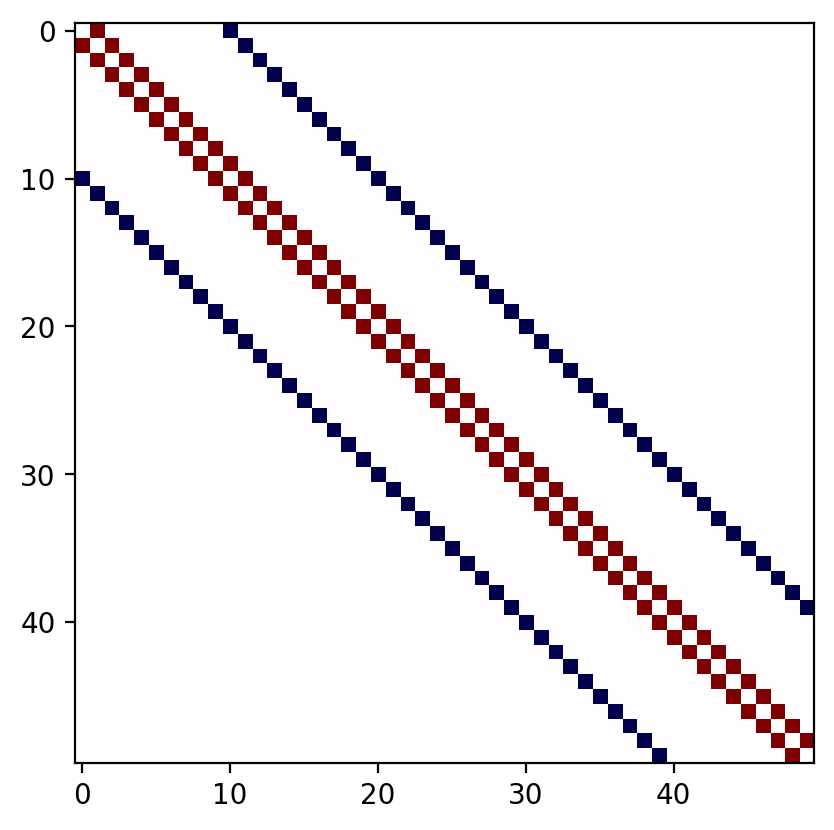

In [5]:
num_nodes, dims = 400, 3

n,d = num_nodes, dims
loop = 10
a = 1e-1

# init_sigma = 3.0 # initial standard deviation of the coordinates
# an initial std of 
init_sigma = n**(1/3)/2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

A = cg.utils.line_graph_A(n, k=1).to(device)
vdw = cg.utils.line_graph_A(n, k=loop).to(device)

A_loop = A+a*vdw

x = init_sigma*torch.randn(n, d).to(device) 

plt.imshow(V(A-vdw)[:50,:50], cmap='seismic', vmin=-1, vmax=1)

In [6]:
energy_params = dict(radius = 1, thres_A = 1e-4, lj_pow = 6, repel_pow = 1, repel_mag = 2.5e-3, 
                device = 'cuda')

energy_lj = Energy([A_loop], [LJ_potential],log_name='Energy_LJ_2scale', **energy_params)
energy_bond_lj = Energy([A, .1*vdw], [quadratic_potential, LJ_potential],log_name='Energy_Bond_LJ', **energy_params)

In [7]:
energy_bond_lj(x).item(), energy_lj(x).item()

(68.68220520019531, 0.0073435078375041485)

## Training

In [10]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-6

# learning rate
LR = 2e-2

In [11]:
# exp_logger = ExperimentLogger(previous_results_csv='../results/CG_experiment_2024-02-09-01.csv')
exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
test_logger = ExperimentLogger(save_prefix='../results/test')

In [14]:
df = exp_logger.df

AttributeError: 'ExperimentLogger' object has no attribute 'df'

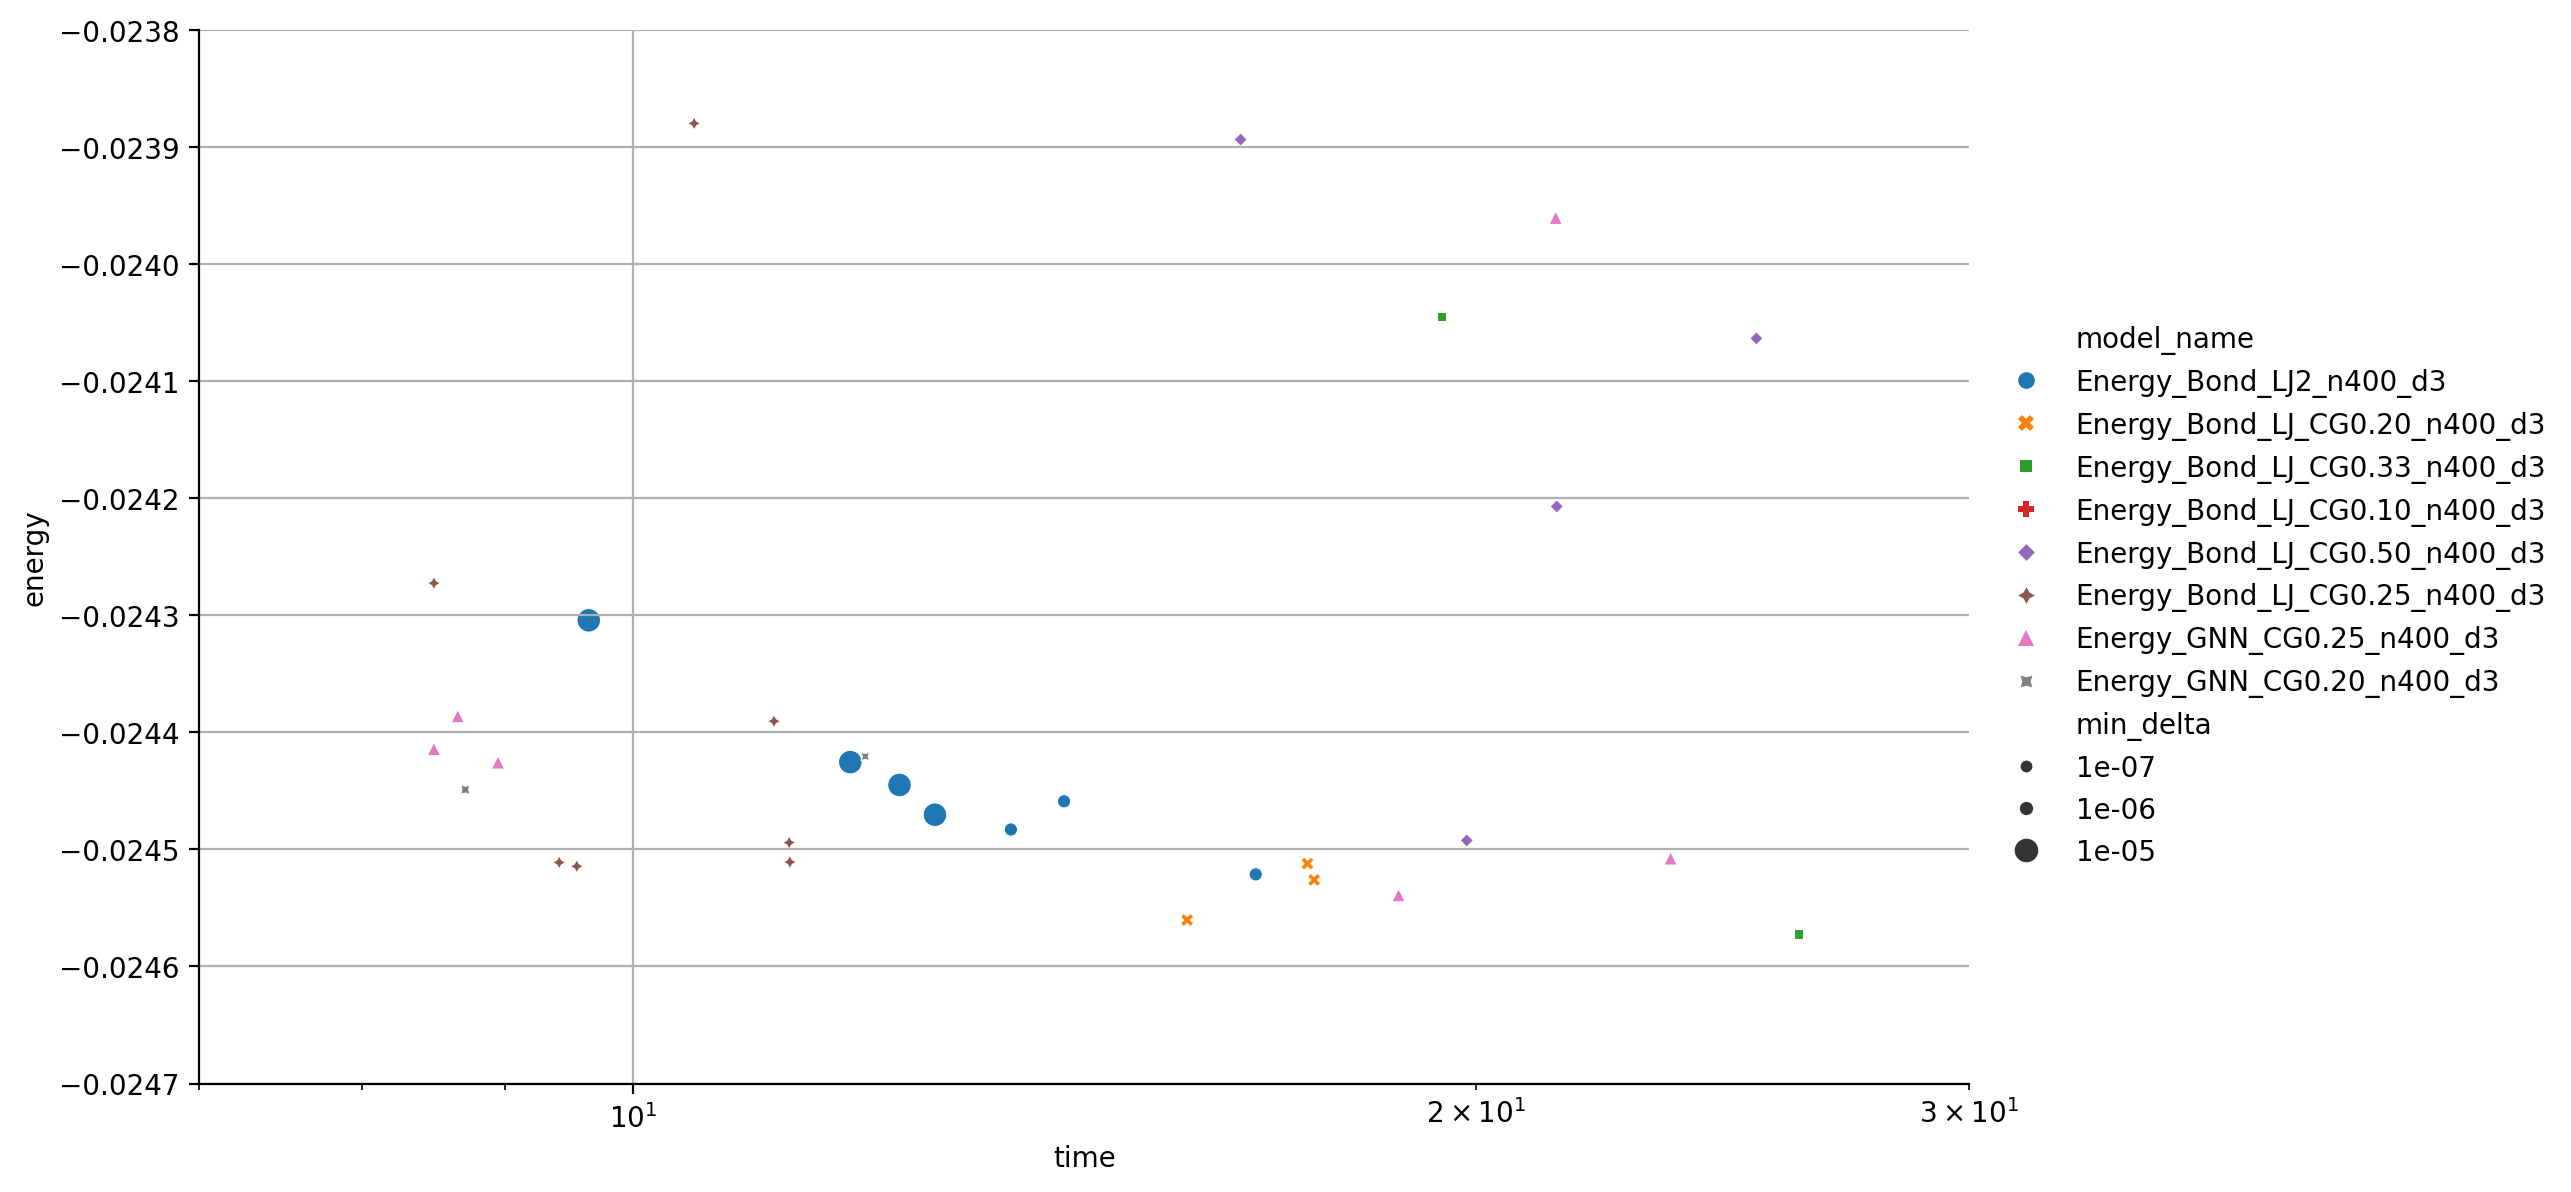

In [227]:
# plot the filtered dataframe using sns directly on df
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='min_delta', height=6, aspect=1.7)

plt.ylim(-.0247, -.0238)
plt.xlim(7,30)
plt.xscale('log')
plt.grid()

## LJ only

In [10]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) /2

initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
# instantiate the EnergyMinimizerPytorch class
# energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=.1, log_step=20, log_pos_step=0, 
#                             log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)
energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-3, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)

Using Adam optimizer
Log name: LJ_loop
Logging to: ../results/logs/LJ_loop_n400_d3


In [11]:
r = 1.5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
exp_logger.run_experiment(energy_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment LJ_loop_n400_d3
250 -0.107, 3.74
500 -0.112, 7.24
750 -0.113, 10.72
1000 -0.113, 14.21
Early stopping at step 380
1020 -0.113, 14.48


Text(0.5, 1.0, 'Energy vs time (min E: -0.113, t=14.48 s)')

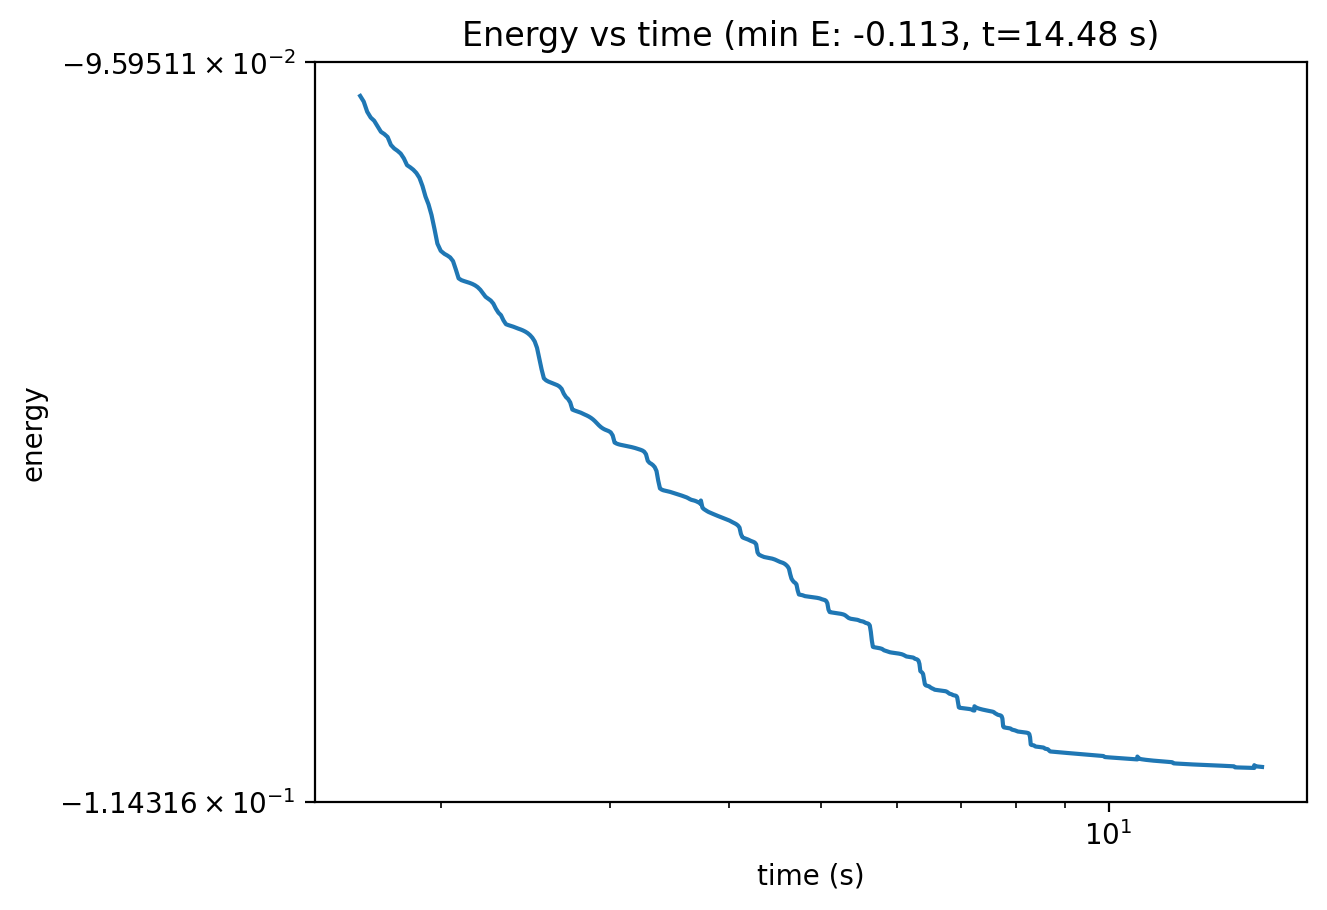

In [13]:
energy_minimizer.plot_history(start=100)
h = energy_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [14]:
exp_logger.df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std
0,Energy_LJ_2scale,LJ_loop_n400_d3,-0.113457,14.482051,0.001,0.01,20,0.000001,1.221912


In [49]:
energy_minimizer.get_x().std(), init_sigma

(tensor(3.3427, device='cuda:0', grad_fn=<StdBackward0>), 3.6840314986403864)

In [15]:
r = 2.5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [44]:

import numpy as np
# import torch
from torch.utils.tensorboard import SummaryWriter

        
# We should move the early stopping functionality into its own class

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.reset()
        
    def reset(self, energy=float('inf')):
        self.best_energy = energy
        self.patience_counter = 0
        self.early_stopping_triggered = False
        
    def check_early_stopping(self, energy):
        if energy < self.best_energy - self.min_delta:
            self.reset(energy)
        else:
            self.patience_counter += 1
            self.early_stopping_triggered = False
        if self.patience_counter >= self.patience:
            self.early_stopping_triggered = True
            # print("Early stopping")
            
# logger class 
# we want to take out the loggng parts from the minimizer class and experiment logger and put them in a separate class
# we can then use the logger class in the minimizer and experiment logger
# the class should be able to log to tensorboard and to a csv file
# we can also use the class to log the hyperparameters of the model

class EnergyLogger:
    def __init__(self, x_shape, log_dir='../results/logs', log_name=None, log_step=10, log_pos_step=0,):
        self.history = dict(time=[], energy=[], x=[])
        self._last_time = 0.
        self._log_step = log_step
        self._log_pos_step = log_pos_step
        self._time_since_train_start = 0.
        self._last_time = 0.
        self.get_log_dir(log_dir, x_shape, log_name)
        self.writer = SummaryWriter(log_dir=self.log_path)
        # save hyperparameters
        self.writer.add_hparams({'log_step': self._log_step, 'log_pos_step': self._log_pos_step,}, {})
            
    def get_log_dir(self, log_dir,x_shape, log_name = None):
        if log_name is not None:
            self.log_name = log_name
        else:
            try: 
                self.log_name = self.energy_func.__qualname__.split('.')[0].lstrip('get_') 
            except:
                try:
                    self.log_name = self.energy_func.__class__.__name__
                except:
                    self.log_name = 'energy'
        print('Log name:',self.log_name)
        # use the shape of the initial_pos in the name of the log file
        self.log_name += f'_n{x_shape[0]}_d{x_shape[1]}'
        self.log_path = os.path.join(log_dir, self.log_name)
        print('Logging to:', self.log_path)
        
    def start_log_epoch(self):
        # to get an accurate measure of the time it takes to compute the energy
        self.update_start_time()
        # self._time_since_train_start = time.time()
        self._start_time = time.time()
        
    def log(self, step, energy, x=None):
        # logging costs time, so use it every k steps
        if step % self._log_step == 0:
            end_time = time.time()
            elapsed_time = end_time - self._start_time
            # total_time = end_time - self._time_since_train_start    
            self.log_step(step, energy, elapsed_time, x)
            self._start_time = end_time
        
    def log_step(self, batch_idx, energy, elapsed_time, x=None):
        self.writer.add_scalar('Energy', energy, batch_idx)
        self.writer.add_scalar('Time', elapsed_time, batch_idx)
        # also append to history
        self.history['time'].append(elapsed_time)
        self.history['energy'].append(energy)
        if self._log_pos_step > 0 and batch_idx % self._log_pos_step == 0:
            if x is not None:
                self.history['x'].append(x.detach().clone().numpy())
    
    def update_start_time(self):
        if self._time_since_train_start == 0:
            self._time_since_train_start = time.time()
        else:
            # we have trained before, so we need to update the time
            # use the last time logged to update the time since training start
            self._time_since_train_start = time.time() - self.history['time'][-1] 
        # we will use self._last_time to update the time since training start
        self._last_time = time.time()
    
# Can we define the energy minimizer a bit more generally?
# We can define the energy minimizer as a subclass of the PyTorch Module
# We want the train_step method to be subclass independent
# the main difference between the subclasses will be the forward method
# and the parameters that are optimized
# we only need to change the clamp_grads and the optimizer
# we can use the same training loop for all subclasses
# we can also use the same logging and early stopping mechanism
# we can also use the same plotting method
# for clamping, we can use the clamp_grads parameter
# for the optimizer, we can use the optimizer_type parameter
# we can also use the same logging and early stopping mechanism


# Pure pytorch implementation of the EnergyMinimizer


class EnergyMinimizerPytorch1(torch.nn.Module):
    def __init__(self, energy_func, initial_pos, optimizer_type=None, lr=0.1, clamp_grads=1., 
                log_step=10, log_pos_step=0, log_dir='../results/logs', patience=5, min_delta=0.0, log_name=None, earlystopping=None):
        """This is a class to minimize the energy of a configuration using PyTorch.
        It uses the energy function to compute the energy of the configuration.

        Args:
            energy_func (_type_): _description_
            initial_pos (_type_): _description_
            optimizer_type (_type_, optional): _description_. Defaults to None.
            lr (float, optional): _description_. Defaults to 0.1.
            clamp_grads (_type_, optional): _description_. Defaults to 1..
            log_step (int, optional): _description_. Defaults to 10.
            log_pos_step (int, optional): _description_. Defaults to 0.
            log_dir (str, optional): _description_. Defaults to '../results/logs'.
            patience (int, optional): _description_. Defaults to 5.
            min_delta (float, optional): _description_. Defaults to 0.0.
        """
        super().__init__()
        self.energy_func = energy_func
        self.optimizer_type = optimizer_type
        self.lr = lr
        self.clamp_grads = clamp_grads
        self.initialize_pos_params(initial_pos)
        
        self.optimizer = self.get_optimizer(self.parameters(), lr=self.lr)
        
        # self.history = dict(time=[], energy=[], x=[])
        # self._last_time = 0.
        # self._log_step = log_step
        # self._log_pos_step = log_pos_step
        # self._time_since_train_start = 0.
        # self._last_time = 0.
        # self.best_energy = float('inf')
        if earlystopping is not None:
            self.early_stop = earlystopping
        else:
            self.early_stop = EarlyStopping(patience=patience, min_delta=min_delta)
        # self.get_log_dir(log_dir, initial_pos, log_name)
        # self.writer = SummaryWriter(log_dir=self.log_path)
        self.logger = EnergyLogger(initial_pos.shape, log_dir, log_name, log_step, log_pos_step,)
        self.history = self.logger.history
        # save hyperparameters
        self.logger.writer.add_hparams({'lr': self.lr, 'clamp_grads': self.clamp_grads, 
                                        # 'log_step': self.logger._log_step, 'log_pos_step': self.logger._log_pos_step, 
                                        'patience': self.early_stop.patience, 'min_delta': self.early_stop.min_delta}, {})
        
    # define patience as a property which also updates the early stopping object
    @property
    def patience(self):
        return self.early_stop.patience
    @patience.setter
    def patience(self, patience):
        self.early_stop.patience = patience
        
    # define min_delta as a property which also updates the early stopping object
    @property
    def min_delta(self):
        return self.early_stop.min_delta
    @min_delta.setter
    def min_delta(self, min_delta):
        self.early_stop.min_delta = min_delta
        
    # property: self.history -> self.logger.history
    # @property
    # def history(self):
    #     return self.logger.history
        
    # def get_log_dir(self, log_dir,x, log_name = None):
    #     if log_name is not None:
    #         self.log_name = log_name
    #     else:
    #         try: 
    #             self.log_name = self.energy_func.__qualname__.split('.')[0].lstrip('get_') 
    #         except:
    #             try:
    #                 self.log_name = self.energy_func.__class__.__name__
    #             except:
    #                 self.log_name = 'energy'
    #     print('Log name:',self.log_name)
    #     # use the shape of the initial_pos in the name of the log file
    #     self.log_name += f'_n{x.shape[0]}_d{x.shape[1]}'
    #     self.log_path = os.path.join(log_dir, self.log_name)
    #     print('Logging to:', self.log_path)
        
    def check_early_stopping(self, energy):
        self.early_stop.check_early_stopping(energy)
        self.early_stopping_triggered = self.early_stop.early_stopping_triggered
        
    def get_optimizer(self, params, **optim_kwargs):
        if self.optimizer_type is not None:
            print(f'Using {self.optimizer_type} optimizer')
            optim = getattr(torch.optim, self.optimizer_type)
        else:
            print('Using Adam optimizer')        
            optim = torch.optim.Adam
        return optim(params, **optim_kwargs)
            
    def initialize_pos_params(self, initial_pos):
        # initialize the position parameters
        # ensure they are registered as nn.parameters
        self.x = torch.nn.Parameter(initial_pos.clone().detach())   
            
    def get_x(self):
        return self.x
    
    def forward(self):
        return self.energy_func(self.get_x())

    def training_step(self,):# batch_idx):
        opt = self.optimizer
        opt.zero_grad()
        # Compute energy
        energy = self.forward()
        energy.backward()
        # clamp gradients to avoid infinities
        # this needs to be done for all parameters of the current optimizer
        for param in opt.param_groups[0]['params']:
            # print(param.shape)
            param.grad = torch.clamp(param.grad, -self.clamp_grads, self.clamp_grads)
        opt.step()
        return energy.item()
            
    # def log(self, batch_idx, energy, elapsed_time):
    #     self.writer.add_scalar('Energy', energy, batch_idx)
    #     self.writer.add_scalar('Time', elapsed_time, batch_idx)
    #     # also append to history
    #     self.history['time'].append(elapsed_time)
    #     self.history['energy'].append(energy)
    #     if self._log_pos_step > 0 and batch_idx % self._log_pos_step == 0:
    #         self.history['x'].append(self.x.detach().clone().numpy())
            
    # train the model
    def train(self, nsteps, update_pairs=True):
        self.logger.start_log_epoch()
        if update_pairs:
            self.energy_func.update_neg_pairs()
            # updating pairs causes the energy to jump, so we need to reset the early stopping
            self.early_stop.reset()
        # # to get an accurate measure of the time it takes to compute the energy
        # self.update_start_time()
        # # self._time_since_train_start = time.time()
        # start_time = time.time()
        for step in range(nsteps):
            energy = self.training_step()
            self.logger.log(step, energy)
            # # logging costs time, so use it every k steps
            # if step % self._log_step == 0:
            #     end_time = time.time()
            #     elapsed_time = end_time - start_time
            #     # total_time = end_time - self._time_since_train_start    
            #     self.log(step, energy, elapsed_time)
            #     start_time = end_time
            # Early stopping        
            self.check_early_stopping(energy)
            if self.early_stopping_triggered:
                print("Early stopping at step", step)
                break
        # because we may call train multiple times,
        # the writer will be closed only when the object is deleted
        # self.writer.close()
        return self.logger.history
    
    # from experimentlogger 
    # def _run_stage(self, model, epochs=10, steps=5000, log_name=None):
    #     log_name = log_name or model.log_name
    #     # start the experiment
    #     self.start_experiment(model.energy_func.log_name, log_name)
    #     print(f'Running experiment {log_name}')
    #     for i in range(epochs):
    #         # train the model
    #         # em.early_stopping_triggered = False
    #         model.energy_func.update_neg_pairs()
    #         h = model.train(steps)
    #         print(len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}")
    #         # log interim result
    #         self.log_result(model.history['energy'][-1], np.sum(model.history['time']),)
    #         if model.early_stopping_triggered:
    #             break
    
    # def update_start_time(self):
    #     if self._time_since_train_start == 0:
    #         self._time_since_train_start = time.time()
    #     else:
    #         # we have trained before, so we need to update the time
    #         # use the last time logged to update the time since training start
    #         self._time_since_train_start = time.time() - self.history['time'][-1] 
    #     # we will use self._last_time to update the time since training start
    #     self._last_time = time.time()
    
    def plot_history(self, start=0, end=None):
        if end is None:
            end = len(self.history['time'])
        plt.plot(np.cumsum(self.history['time'])[start:end], self.history['energy'][start:end])
        plt.xlabel('time (s)')
        plt.ylabel('energy')
        plt.xscale('log')
        plt.yscale('symlog')
        # plt.show()
        


In [13]:
1

1

In [18]:
# logger class 
# we want to take out the loggng parts from the minimizer class and experiment logger and put them in a separate class
# we can then use the logger class in the minimizer and experiment logger
# the class should be able to log to tensorboard and to a csv file
# we can also use the class to log the hyperparameters of the model

class EnergyLogger:
    def __init__(self, log_dir='../results/logs', log_name=None, log_step=10, log_pos_step=0, patience=5, min_delta=0.0):
        self.history = dict(time=[], energy=[], x=[])
        self._last_time = 0.
        self._log_step = log_step
        self._log_pos_step = log_pos_step
        self._time_since_train_start = 0.
        self._last_time = 0.
        self.get_log_dir(log_dir, log_name)
        self.writer = SummaryWriter(log_dir=self.log_path)
        # save hyperparameters
        self.writer.add_hparams({'log_step': self._log_step,
                'log_pos_step': self._log_pos_step, 'patience': self.early_stop.patience, 'min_delta': self.early_stop.min_delta}, {})
            
    def get_log_dir(self, log_dir,x, log_name = None):
        if log_name is not None:
            self.log_name = log_name
        else:
            try: 
                self.log_name = self.energy_func.__qualname__.split('.')[0].lstrip('get_') 
            except:
                try:
                    self.log_name = self.energy_func.__class__.__name__
                except:
                    self.log_name = 'energy'
        print('Log name:',self.log_name)
        # use the shape of the initial_pos in the name of the log file
        self.log_name += f'_n{x.shape[0]}_d{x.shape[1]}'
        self.log_path = os.path.join(log_dir, self.log_name)
        print('Logging to:', self.log_path)
        
    def log(self, batch_idx, energy, elapsed_time, x=None):
        self.writer.add_scalar('Energy', energy, batch_idx)
        self.writer.add_scalar('Time', elapsed_time, batch_idx)
        # also append to history
        self.history['time'].append(elapsed_time)
        self.history['energy'].append(energy)
        if self._log_pos_step > 0 and batch_idx % self._log_pos_step == 0:
            if x is not None:
                self.history['x'].append(x.detach().clone().numpy())
    
    def update_start_time(self):
        if self._time_since_train_start == 0:
            self._time_since_train_start = time.time()
        else:
            # we have trained before, so we need to update the time
            # use the last time logged to update the time since training start
            self._time_since_train_start = time.time() - self.history['time'][-1] 
        # we will use self._last_time to update the time since training start
        self._last_time = time.time()
    

What are we trying to do? What are the outstanding questions? What are the things that work and don't work? 


In [36]:

import numpy as np
# import torch
from torch.utils.tensorboard import SummaryWriter

        
# We should move the early stopping functionality into its own class

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = float('inf')
        self.patience_counter = 0
        self.early_stopping_triggered = False
        
    def check_early_stopping(self, energy):
        if energy < self.best_energy - self.min_delta:
            self.best_energy = energy
            self.patience_counter = 0
            self.early_stopping_triggered = False
        else:
            self.patience_counter += 1
            self.early_stopping_triggered = False
        if self.patience_counter >= self.patience:
            self.early_stopping_triggered = True
            # print("Early stopping")
            
# logger class 
# we want to take out the loggng parts from the minimizer class and experiment logger and put them in a separate class
# we can then use the logger class in the minimizer and experiment logger
# the class should be able to log to tensorboard and to a csv file
# we can also use the class to log the hyperparameters of the model

class EnergyLogger:
    def __init__(self, x_shape, log_dir='../results/logs', log_name=None, log_step=10, log_pos_step=0,):
        self.history = dict(time=[], energy=[], x=[])
        self._last_time = 0.
        self._log_step = log_step
        self._log_pos_step = log_pos_step
        self._time_since_train_start = 0.
        self._last_time = 0.
        self.get_log_dir(log_dir, x_shape, log_name)
        self.writer = SummaryWriter(log_dir=self.log_path)
        # save hyperparameters
        self.writer.add_hparams({'log_step': self._log_step, 'log_pos_step': self._log_pos_step,}, {})
            
    def get_log_dir(self, log_dir,x_shape, log_name = None):
        if log_name is not None:
            self.log_name = log_name
        else:
            try: 
                self.log_name = self.energy_func.__qualname__.split('.')[0].lstrip('get_') 
            except:
                try:
                    self.log_name = self.energy_func.__class__.__name__
                except:
                    self.log_name = 'energy'
        print('Log name:',self.log_name)
        # use the shape of the initial_pos in the name of the log file
        self.log_name += f'_n{x_shape[0]}_d{x_shape[1]}'
        self.log_path = os.path.join(log_dir, self.log_name)
        print('Logging to:', self.log_path)
        
    def start_log_epoch(self):
        # to get an accurate measure of the time it takes to compute the energy
        self.update_start_time()
        # self._time_since_train_start = time.time()
        self._start_time = time.time()
        
    def log(self, step, energy, x=None):
        # logging costs time, so use it every k steps
        if step % self._log_step == 0:
            end_time = time.time()
            elapsed_time = end_time - self._start_time
            # total_time = end_time - self._time_since_train_start    
            self.log_step(step, energy, elapsed_time, x)
            self._start_time = end_time
        
    def log_step(self, batch_idx, energy, elapsed_time, x=None):
        self.writer.add_scalar('Energy', energy, batch_idx)
        self.writer.add_scalar('Time', elapsed_time, batch_idx)
        # also append to history
        self.history['time'].append(elapsed_time)
        self.history['energy'].append(energy)
        if self._log_pos_step > 0 and batch_idx % self._log_pos_step == 0:
            if x is not None:
                self.history['x'].append(x.detach().clone().numpy())
    
    def update_start_time(self):
        if self._time_since_train_start == 0:
            self._time_since_train_start = time.time()
        else:
            # we have trained before, so we need to update the time
            # use the last time logged to update the time since training start
            self._time_since_train_start = time.time() - self.history['time'][-1] 
        # we will use self._last_time to update the time since training start
        self._last_time = time.time()
    
# Can we define the energy minimizer a bit more generally?
# We can define the energy minimizer as a subclass of the PyTorch Module
# We want the train_step method to be subclass independent
# the main difference between the subclasses will be the forward method
# and the parameters that are optimized
# we only need to change the clamp_grads and the optimizer
# we can use the same training loop for all subclasses
# we can also use the same logging and early stopping mechanism
# we can also use the same plotting method
# for clamping, we can use the clamp_grads parameter
# for the optimizer, we can use the optimizer_type parameter
# we can also use the same logging and early stopping mechanism


# Pure pytorch implementation of the EnergyMinimizer


class EnergyMinimizerPytorch1(torch.nn.Module):
    def __init__(self, energy_func, initial_pos, optimizer_type=None, lr=0.1, clamp_grads=1., 
                log_step=10, log_pos_step=0, log_dir='../results/logs', patience=5, min_delta=0.0, log_name=None, earlystopping=None):
        """This is a class to minimize the energy of a configuration using PyTorch.
        It uses the energy function to compute the energy of the configuration.

        Args:
            energy_func (_type_): _description_
            initial_pos (_type_): _description_
            optimizer_type (_type_, optional): _description_. Defaults to None.
            lr (float, optional): _description_. Defaults to 0.1.
            clamp_grads (_type_, optional): _description_. Defaults to 1..
            log_step (int, optional): _description_. Defaults to 10.
            log_pos_step (int, optional): _description_. Defaults to 0.
            log_dir (str, optional): _description_. Defaults to '../results/logs'.
            patience (int, optional): _description_. Defaults to 5.
            min_delta (float, optional): _description_. Defaults to 0.0.
        """
        super().__init__()
        self.energy_func = energy_func
        self.optimizer_type = optimizer_type
        self.lr = lr
        self.clamp_grads = clamp_grads
        self.initialize_pos_params(initial_pos)
        
        self.optimizer = self.get_optimizer(self.parameters(), lr=self.lr)
        
        # self.history = dict(time=[], energy=[], x=[])
        # self._last_time = 0.
        # self._log_step = log_step
        # self._log_pos_step = log_pos_step
        # self._time_since_train_start = 0.
        # self._last_time = 0.
        self.best_energy = float('inf')
        if earlystopping is not None:
            self.early_stop = earlystopping
        else:
            self.early_stop = EarlyStopping(patience=patience, min_delta=min_delta)
        # self.get_log_dir(log_dir, initial_pos, log_name)
        # self.writer = SummaryWriter(log_dir=self.log_path)
        self.logger = EnergyLogger(initial_pos.shape, log_dir, log_name, log_step, log_pos_step,)
        # save hyperparameters
        self.logger.writer.add_hparams({'lr': self.lr, 'clamp_grads': self.clamp_grads, 
                                        # 'log_step': self.logger._log_step, 'log_pos_step': self.logger._log_pos_step, 
                                        'patience': self.early_stop.patience, 'min_delta': self.early_stop.min_delta}, {})
        
    # define patience as a property which also updates the early stopping object
    @property
    def patience(self):
        return self.early_stop.patience
    @patience.setter
    def patience(self, patience):
        self.early_stop.patience = patience
        
    # define min_delta as a property which also updates the early stopping object
    @property
    def min_delta(self):
        return self.early_stop.min_delta
    @min_delta.setter
    def min_delta(self, min_delta):
        self.early_stop.min_delta = min_delta
        
    # property: self.history -> self.logger.history
    @property
    def history(self):
        return self.logger.history
        
    # def get_log_dir(self, log_dir,x, log_name = None):
    #     if log_name is not None:
    #         self.log_name = log_name
    #     else:
    #         try: 
    #             self.log_name = self.energy_func.__qualname__.split('.')[0].lstrip('get_') 
    #         except:
    #             try:
    #                 self.log_name = self.energy_func.__class__.__name__
    #             except:
    #                 self.log_name = 'energy'
    #     print('Log name:',self.log_name)
    #     # use the shape of the initial_pos in the name of the log file
    #     self.log_name += f'_n{x.shape[0]}_d{x.shape[1]}'
    #     self.log_path = os.path.join(log_dir, self.log_name)
    #     print('Logging to:', self.log_path)
        
    def check_early_stopping(self, energy):
        self.early_stop.check_early_stopping(energy)
        self.early_stopping_triggered = self.early_stop.early_stopping_triggered
        
    def get_optimizer(self, params, **optim_kwargs):
        if self.optimizer_type is not None:
            print(f'Using {self.optimizer_type} optimizer')
            optim = getattr(torch.optim, self.optimizer_type)
        else:
            print('Using Adam optimizer')        
            optim = torch.optim.Adam
        return optim(params, **optim_kwargs)
            
    def initialize_pos_params(self, initial_pos):
        # initialize the position parameters
        # ensure they are registered as nn.parameters
        self.x = torch.nn.Parameter(initial_pos.clone().detach())   
            
    def get_x(self):
        return self.x
    
    def forward(self):
        return self.energy_func(self.get_x())

    def training_step(self,):# batch_idx):
        opt = self.optimizer
        opt.zero_grad()
        # Compute energy
        energy = self.forward()
        energy.backward()
        # clamp gradients to avoid infinities
        # this needs to be done for all parameters of the current optimizer
        for param in opt.param_groups[0]['params']:
            # print(param.shape)
            param.grad = torch.clamp(param.grad, -self.clamp_grads, self.clamp_grads)
        opt.step()
        return energy.item()
            
    # def log(self, batch_idx, energy, elapsed_time):
    #     self.writer.add_scalar('Energy', energy, batch_idx)
    #     self.writer.add_scalar('Time', elapsed_time, batch_idx)
    #     # also append to history
    #     self.history['time'].append(elapsed_time)
    #     self.history['energy'].append(energy)
    #     if self._log_pos_step > 0 and batch_idx % self._log_pos_step == 0:
    #         self.history['x'].append(self.x.detach().clone().numpy())
            
    # train the model
    def train(self, nsteps, update_pairs=True):
        self.logger.start_log_epoch()
        if update_pairs:
            self.energy_func.update_neg_pairs()
            # updating pairs causes the energy to jump, so we need to reset best_energy
            self.best_energy = float('inf')
        # # to get an accurate measure of the time it takes to compute the energy
        # self.update_start_time()
        # # self._time_since_train_start = time.time()
        # start_time = time.time()
        for step in range(nsteps):
            energy = self.training_step()
            self.logger.log(step, energy)
            # # logging costs time, so use it every k steps
            # if step % self._log_step == 0:
            #     end_time = time.time()
            #     elapsed_time = end_time - start_time
            #     # total_time = end_time - self._time_since_train_start    
            #     self.log(step, energy, elapsed_time)
            #     start_time = end_time
            # Early stopping        
            self.check_early_stopping(energy)
            if self.early_stopping_triggered:
                print("Early stopping at step", step)
                break
        # because we may call train multiple times,
        # the writer will be closed only when the object is deleted
        # self.writer.close()
        return self.logger.history
    
    # from experimentlogger 
    # def _run_stage(self, model, epochs=10, steps=5000, log_name=None):
    #     log_name = log_name or model.log_name
    #     # start the experiment
    #     self.start_experiment(model.energy_func.log_name, log_name)
    #     print(f'Running experiment {log_name}')
    #     for i in range(epochs):
    #         # train the model
    #         # em.early_stopping_triggered = False
    #         model.energy_func.update_neg_pairs()
    #         h = model.train(steps)
    #         print(len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}")
    #         # log interim result
    #         self.log_result(model.history['energy'][-1], np.sum(model.history['time']),)
    #         if model.early_stopping_triggered:
    #             break
    
    # def update_start_time(self):
    #     if self._time_since_train_start == 0:
    #         self._time_since_train_start = time.time()
    #     else:
    #         # we have trained before, so we need to update the time
    #         # use the last time logged to update the time since training start
    #         self._time_since_train_start = time.time() - self.history['time'][-1] 
    #     # we will use self._last_time to update the time since training start
    #     self._last_time = time.time()
    
    def plot_history(self, start=0, end=None):
        if end is None:
            end = len(self.history['time'])
        plt.plot(np.cumsum(self.history['time'])[start:end], self.history['energy'][start:end])
        plt.xlabel('time (s)')
        plt.ylabel('energy')
        plt.xscale('log')
        plt.yscale('symlog')
        # plt.show()
        


In [ ]:
# To collect and plot results, use a list of dictionaries
import datetime

import numpy as np
import pandas as pd
import seaborn as sns


class ExperimentLogger:
    def __init__(self, save_prefix = '../results/CG_experiment_', previous_results_csv = None):
        self.results = []
        self.save_prefix = save_prefix
        self.current_experiment = None
        # load previous results as a pd dataframe, if path is given
        # assume the path is a csv file
        if previous_results_csv is not None:
            self.results = pd.read_csv(previous_results_csv).to_dict('records')

    def start_experiment(self, energy_function, # num_nodes, 
                        model_name):
        self.current_experiment = {
            'energy_function': energy_function,
            # 'num_nodes': num_nodes,
            'model_name': model_name,
            'energy': None,
            'time': None
        }
        

    def log_result(self, energy, time, **kws):
        if self.current_experiment is not None:
            self.current_experiment['energy'] = energy
            self.current_experiment['time'] = time
            # allow for additional keyword arguments to be logged
            self.current_experiment.update(kws)

    def end_experiment(self):
        if self.current_experiment is not None:
            self.results.append(self.current_experiment)
            self.current_experiment = None
    
    
    def run_experiment(self, model, epochs=10, steps=5000, log_name=None, **extra_log_kws):
        self._run_stage(model, epochs, steps, log_name)
        # log the result
        self._log_stage(model, **extra_log_kws)
        # end the experiment
        self.end_experiment()
        # save csv after each experiment
        self.to_csv() 
        
    def run_experiment_cg(self, model, cg_mode_time, epochs=10, steps=5000, log_name=None, **extra_log_kws):
        self._run_stage(model, epochs, steps, log_name)
        # log the result
        self._log_stage_cg(model, cg_mode_time, **extra_log_kws)
        # end the experiment
        self.end_experiment()
        # save csv after each experiment
        self.to_csv()
        
    def run_experiment_gnn(self, model, cg_mode_time, epochs=10, steps=5000, log_name=None, **extra_log_kws):
        self._run_stage(model, epochs, steps, log_name)
        # log the result
        self._log_stage_gnn(model, cg_mode_time, **extra_log_kws)
        # end the experiment
        self.end_experiment()
        # save csv after each experiment
        self.to_csv()
                
    def _run_stage(self, model, epochs=10, steps=5000, log_name=None):
        log_name = log_name or model.log_name
        # start the experiment
        self.start_experiment(model.energy_func.log_name, log_name)
        print(f'Running experiment {log_name}')
        for i in range(epochs):
            # train the model
            # em.early_stopping_triggered = False
            model.energy_func.update_neg_pairs()
            h = model.train(steps)
            print(len(h['energy']), f"{h['energy'][-1]:.3g}, {np.sum(h['time']):.2f}")
            # log interim result
            self.log_result(model.history['energy'][-1], np.sum(model.history['time']),)
            if model.early_stopping_triggered:
                break
            
    def _log_stage(self, model, **extra_log_kws):
        # log the result
        self.log_result(model.history['energy'][-1], np.sum(model.history['time']),
                    # log hyperparameters such as patience and min_delta
                    lr=model.lr, clamp_grads=model.clamp_grads,
                    patience=model.patience, min_delta=model.min_delta, 
                    **extra_log_kws)    
        
    def _log_stage_cg(self, model, cg_mode_time, **extra_log_kws):
        self.log_result(model.history['energy'][-1], np.sum(model.history['time'])+cg_mode_time,
                # log hyperparameters such as patience and min_delta
                lr=model.lr, lr_cg=model.lr_cg, clamp_grads=model.clamp_grads,
                patience=model.fg_patience, min_delta=model.fg_min_delta, 
                cg_patience=model.cg_patience, cg_min_delta=model.cg_min_delta,
                cg_steps=model.cg_steps, 
                cg_time=np.sum(model.history['time'][:model.cg_steps])+cg_mode_time, 
                cg_energy=model.history['energy'][model.cg_steps-1],
                **extra_log_kws)
        
    def _log_stage_gnn(self, model, cg_mode_time, **extra_log_kws):
        self.log_result(model.history['energy'][-1], np.sum(model.history['time'])+cg_mode_time,
                # log hyperparameters such as patience and min_delta
                num_cg_modes=model.gnn.num_cg,
                lr=model.lr, lr_cg=model.lr_gnn, clamp_grads=model.clamp_grads,
                patience=model.fg_patience, min_delta=model.fg_min_delta, 
                cg_patience=model.gnn_patience, cg_min_delta=model.gnn_min_delta,
                cg_steps=model.gnn_steps, 
                cg_time=np.sum(model.history['time'][:model.gnn_steps])+cg_mode_time, 
                cg_energy=model.history['energy'][model.gnn_steps-1],
                hidden_dims=model.gnn.hidden_dims,
                **extra_log_kws)
            
    def to_dataframe(self):
        return pd.DataFrame(self.results)
    
    def to_csv(self):
        self.df = self.to_dataframe()
        self.df.to_csv(self.save_prefix + datetime.datetime.now().strftime("%Y-%m-%d-%H") + '.csv', index=False)
        
    def plot_results(self, x='time', y='energy', hue='model_name', style='energy_function'):
        # plot as scatter plot
        sns.relplot(data = self.df, x=x, y=y, hue=hue, style=style, kind='scatter')
        # sns.relplot(data = self.df, x=x, y=y, hue=hue, style=style, kind='line')
        
    # when object itself is printed, print the dataframe
    def __repr__(self):
        # only make the dataframe if it doesn't exist
        if not hasattr(self, 'df'):
            self.df = self.to_dataframe()
        # We wnat ensure that the dataframe displayed in the fancy format in the notebook
        # so we use the _repr_html_ method
        return self.df._repr_html_()
        # return self.df
        

In [15]:
from coarsegrainer.experimental.minimizer import EnergyMinimizerPytorch as EnergyMinimizerPytorch_exp

In [45]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) /2

initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
# instantiate the EnergyMinimizerPytorch class
# energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=.1, log_step=20, log_pos_step=0, 
#                             log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)
energy_minimizer = EnergyMinimizerPytorch1(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-3, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)

Using Adam optimizer
Log name: LJ_loop
Logging to: ../results/logs/LJ_loop_n400_d3


In [46]:
# energy_minimizer.early_stopping_triggered =False

In [52]:
h = energy_minimizer.train(5000)

Early stopping at step 1324


In [53]:
r = 2.5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

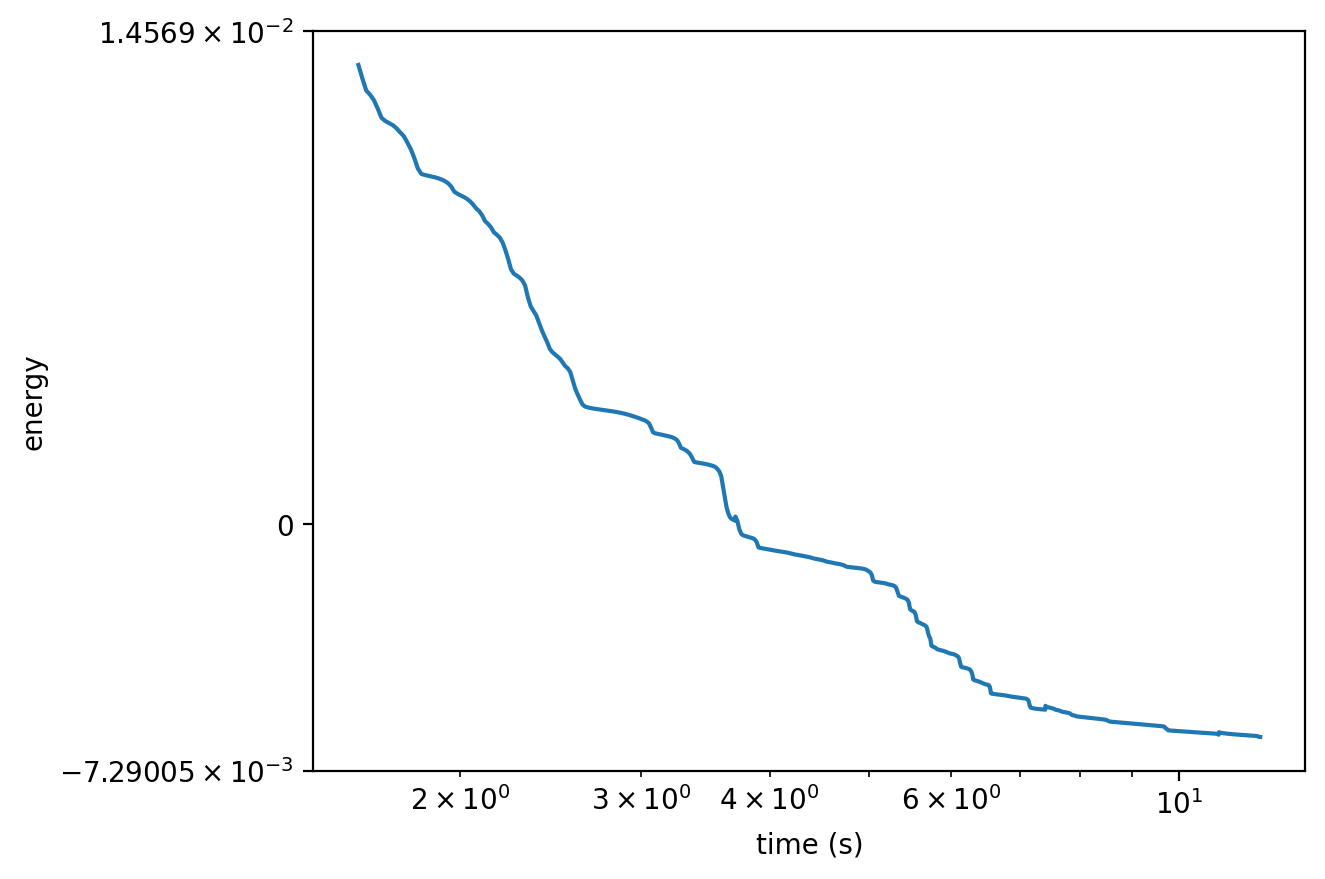

In [54]:
energy_minimizer.plot_history(start=100)

In [16]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) /2

initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
# instantiate the EnergyMinimizerPytorch class
# energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=.1, log_step=20, log_pos_step=0, 
#                             log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)
energy_minimizer = EnergyMinimizerPytorch_exp(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-3, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)

Using Adam optimizer
Log name: LJ_loop
Logging to: ../results/logs/LJ_loop_n400_d3


In [19]:
exp_logger.run_experiment(energy_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

AttributeError: 'EnergyMinimizerPytorch1' object has no attribute 'log_name'

Text(0.5, 1.0, 'Energy vs time (min E: -0.115, t=10.15 s)')

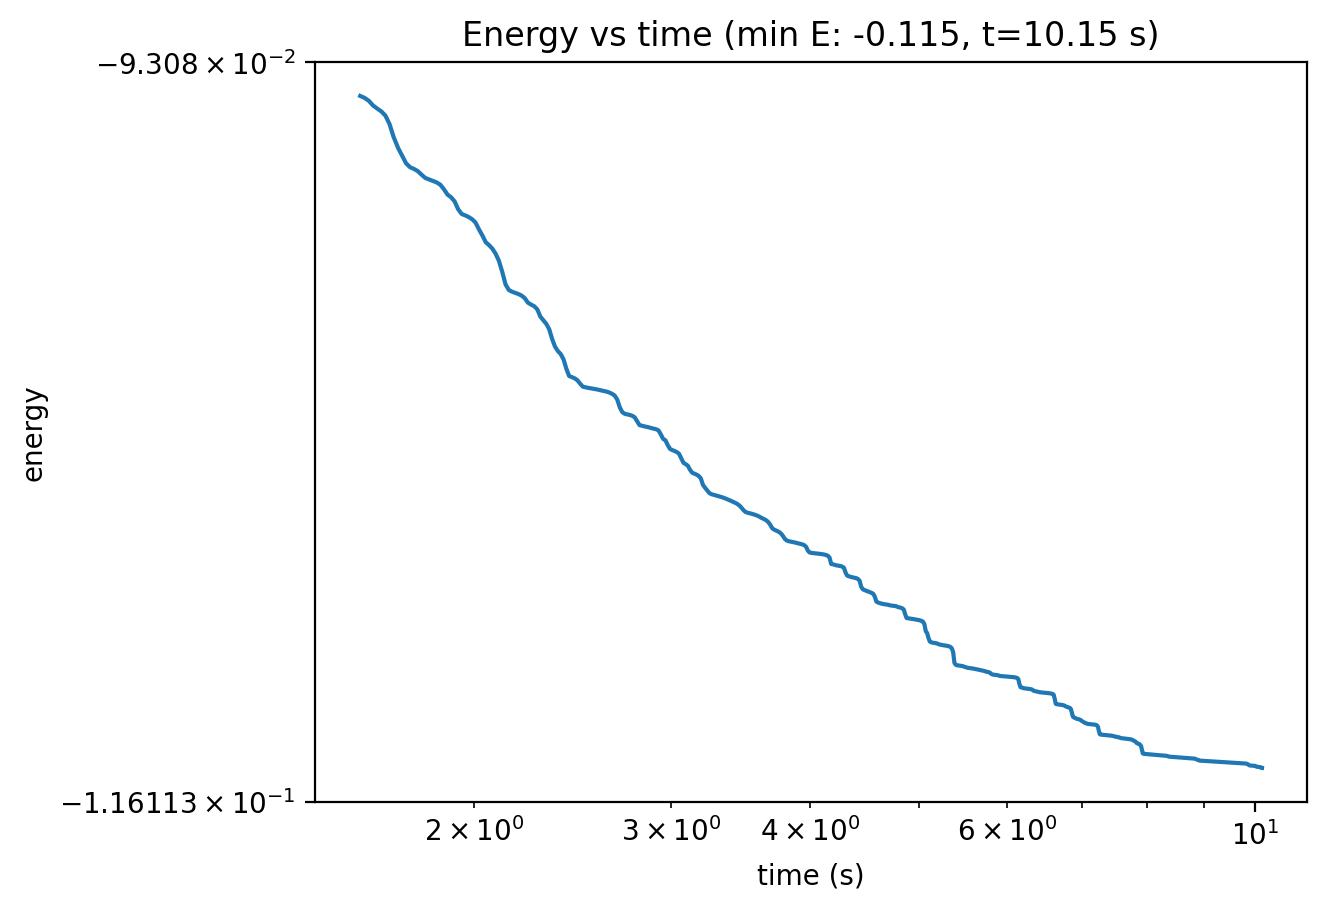

In [21]:
energy_minimizer.plot_history(start=100)
h = energy_minimizer.logger.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [18]:
exp_logger.df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std
0,Energy_LJ_2scale,LJ_loop_n400_d3,0.10498,10.997405,0.001,0.01,20,0.000001,1.209066


In [19]:
energy_minimizer.get_x().std(), init_sigma

(tensor(2.1556, device='cuda:0', grad_fn=<StdBackward0>), 3.6840314986403864)

In [28]:
r = 2.5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### CG Using multiple samples

In [51]:
init_sigma

3.6840314986403864

In [34]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 40
# produce k samples with different std for x
x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-2, 2e-1, k)[:, None, None].to(device)
# x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-1, 2e-0, k)[:, None, None].to(device)
cg_bond_lj = cg.CG.CoarseGrainer(energy_lj, num_cg_modes=120)
cg_bond_lj.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.28 seconds
spectrum of the Laplacian computed in 0.01 seconds


0.2922096252441406

In [35]:
init_sigma/16, 1/(2*d)

(0.23025196866502415, 0.16666666666666666)

In [36]:
A.shape, x.shape

(torch.Size([400, 400]), torch.Size([400, 3]))

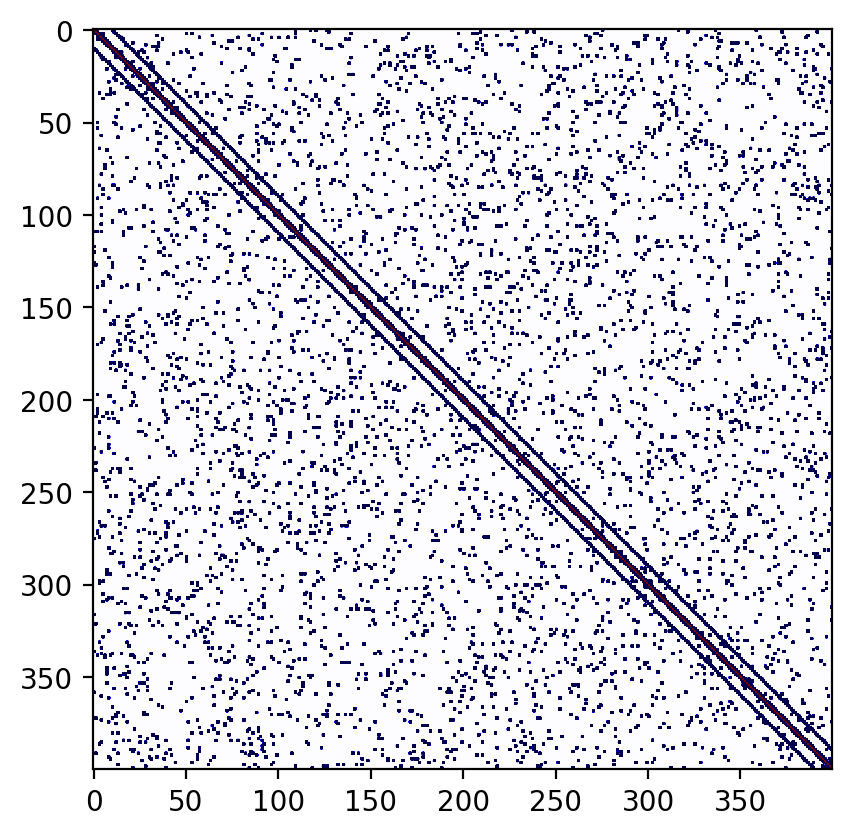

In [37]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


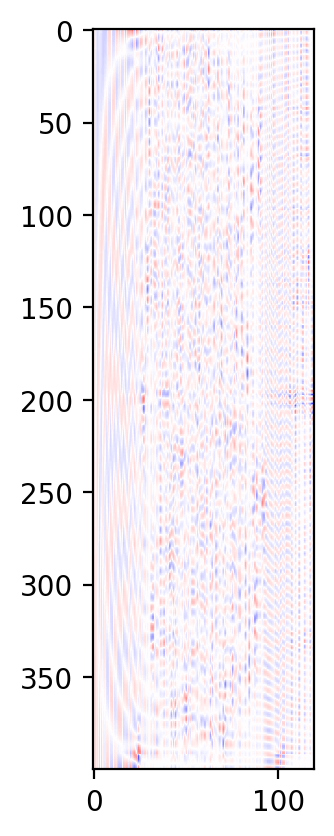

In [38]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [39]:
# cg_minimizer.start_fine_graining()
# cg_minimizer.early_stopping_triggered = False
# h = cg_minimizer.train(20000)

### Multi-stage CG
gradually increase the number cg modes used

In [20]:
cg_min_params = dict(optimizer_type='Adam', lr=1e-3, lr_cg=1e-1,
            clamp_grads=.01, log_step=20, log_pos_step=0, 
            log_dir='../results/logs', log_name='CG_LJ_loop', 
            patience=PATIENCE, min_delta=MIN_DELTA,
            cg_patience=PATIENCE, cg_min_delta=MIN_DELTA*10)

In [21]:
num_cg_modes = n//4
initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
# instantiate the CGMinimizerPytorch class
cg_minimizer = CGMinimizerPytorch(energy_lj, initial_pos, cg_bond_lj.cg_modes[:,:num_cg_modes], **cg_min_params)

Using Adam optimizer
Log name: CG_LJ_loop
Logging to: ../results/logs/CG_LJ_loop_n400_d3
Using Adam optimizer


In [22]:
exp_logger.run_experiment(cg_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment CG_LJ_loop_n400_d3
250 0.231, 4.10
500 0.226, 7.94
Early stopping at step 1720
Starting fine-graining
837 0.196, 12.93
1087 0.193, 16.59
1337 0.193, 20.24
Early stopping at step 320
1354 0.193, 20.47


In [23]:
cg_minimizer.cg_steps

587

Text(0.5, 1.0, 'Energy vs time (min E: 0.193, t=20.47 s)')

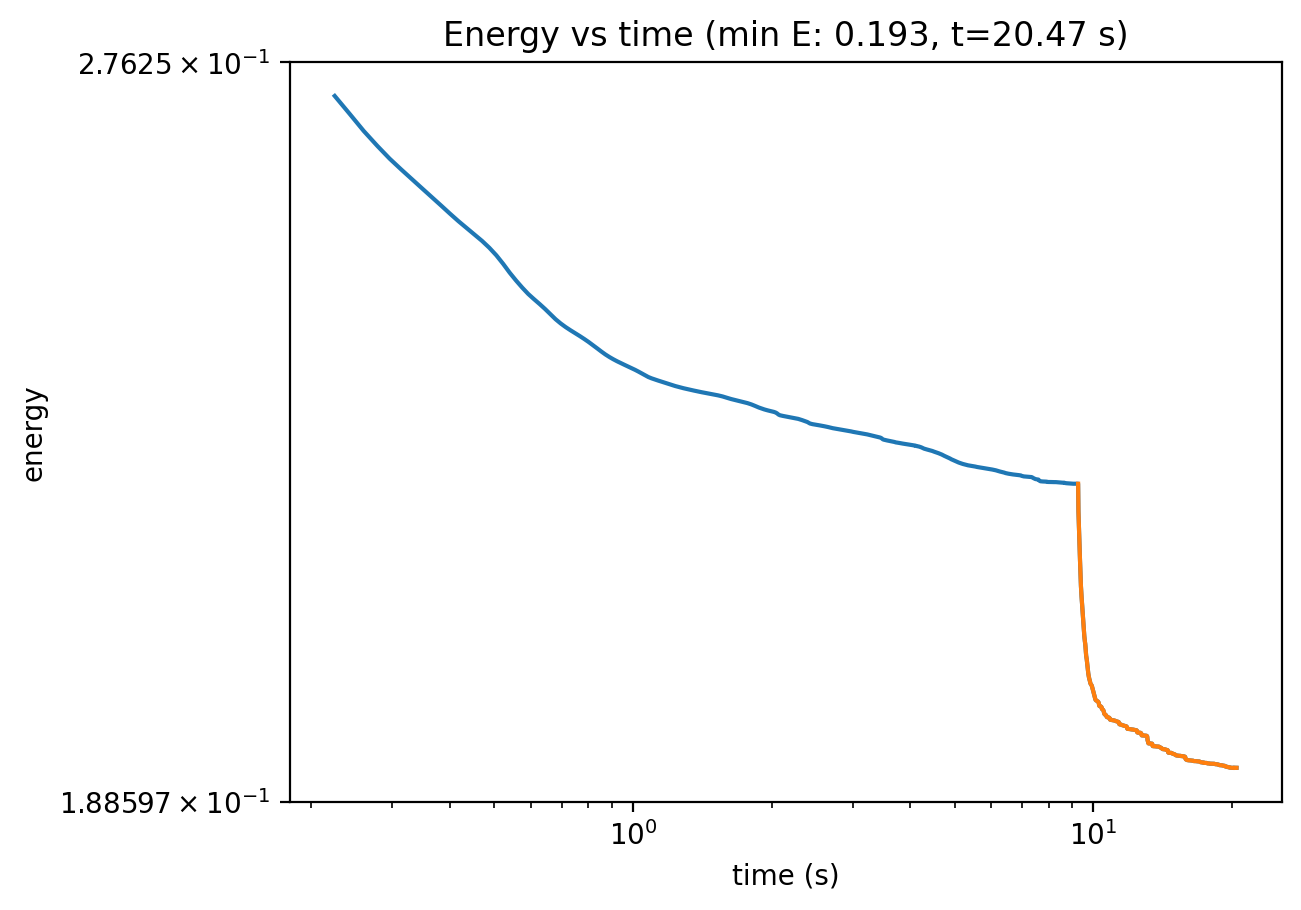

In [27]:
cg_minimizer.plot_history(start=10)
cg_minimizer.plot_history(start=cg_minimizer.cg_steps)
h = cg_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [28]:
cg_minimizer.fine_grained

True

In [29]:
r = 5e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_minimizer.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
h = cg_minimizer.train_one_stage(20000)

Early stopping at step 0


{'time': [0.0384974479675293,
  0.020319223403930664,
  0.018326282501220703,
  0.01755380630493164,
  0.01748180389404297,
  0.017602920532226562,
  0.020549297332763672,
  0.01880502700805664,
  0.019991159439086914,
  0.018091440200805664,
  0.017705440521240234,
  0.017510175704956055,
  0.017612934112548828,
  0.018502235412597656,
  0.017473459243774414,
  0.017475366592407227,
  0.017421483993530273,
  0.01742100715637207,
  0.01735663414001465,
  0.01729583740234375,
  0.017351627349853516,
  0.01734185218811035,
  0.017358779907226562,
  0.017400741577148438,
  0.01758599281311035,
  0.017403602600097656,
  0.017495393753051758,
  0.017384767532348633,
  0.017403125762939453,
  0.01751708984375,
  0.017374038696289062,
  0.01740121841430664,
  0.017374038696289062,
  0.017429828643798828,
  0.0174100399017334,
  0.017516136169433594,
  0.017372608184814453,
  0.01744699478149414,
  0.017401933670043945,
  0.01741957664489746,
  0.017400264739990234,
  0.017369508743286133,
  0

In [ ]:
cg_minimizer.history.keys()

dict_keys(['time', 'energy', 'x'])

In [31]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 10
# produce k samples with different std for x

x0 = cg_minimizer.get_x().detach().clone()
s = x0.std().item()

x_samples = s/10*torch.randn(k, n, d, device = device)*torch.linspace(2e-1, 1e0, k)[:, None, None].to(device)
x_samples = x_samples + x0

cg_bond_lj = cg.CG.CoarseGrainer(energy_lj, num_cg_modes=120)
cg_bond_lj.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.07 seconds
spectrum of the Laplacian computed in 0.01 seconds


0.08814072608947754

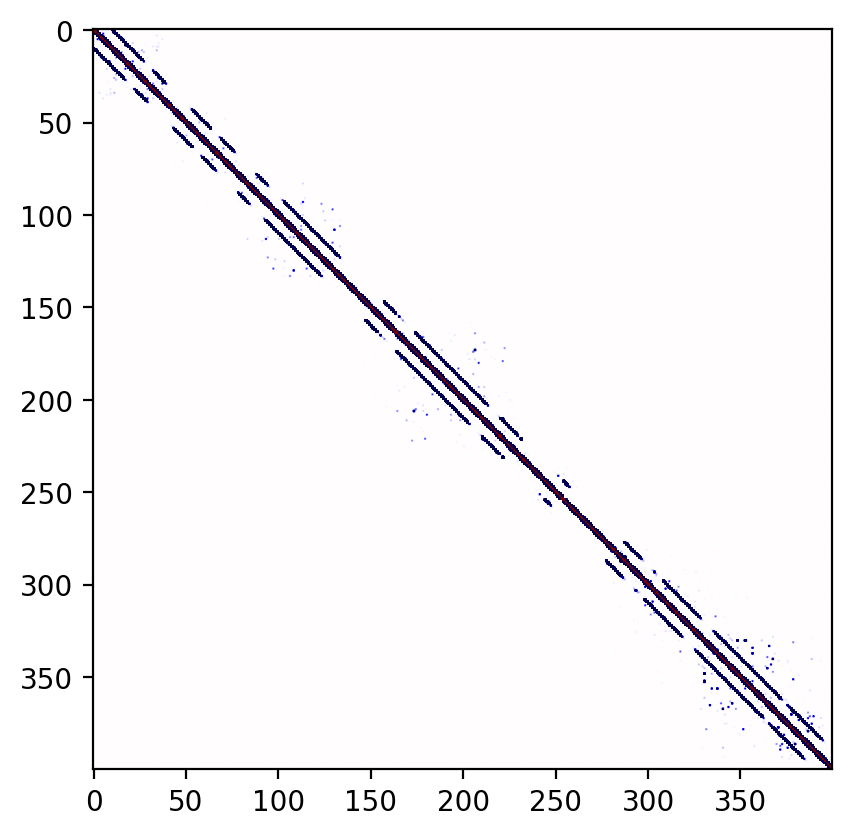

In [32]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


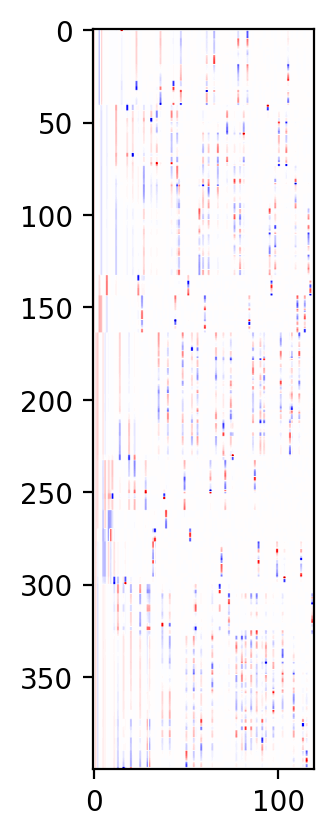

In [33]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [ ]:
h = cg_bond_lj.hessian(cg_minimizer.get_x())

NameError: name 'cg_minimizer' is not defined

In [ ]:
plt.imshow(np.arcsinh(1e3*V(h.norm(dim=(1,3))))[:100,:100], cmap='seismic', vmin=-1, vmax=1)


NameError: name 'h' is not defined